# UFO Sightings: An Intro to Data Science
### By Nadeem Saleh and Ayman Hammad

## Introduction

Have you ever wondered if we're alone in the universe? From books to movies and TV shows, aliens and UFOs have been a part of pop-culture since around the 1940s. A huge number of people (e.g. Fox Mulder) believe they were involved in a close encounter of the first, second, or third kind. 

You might be wondering:
- What areas of the country are most likely to have UFO sightings?
- Are there any trends in UFO sightings over time?
- What are the most common UFO descriptions?
- How long do sightings occur?
- Do sightings cluster around airports?

We'll to try to answer these questions through the power of data science. We will take you through the data science pipeline- from data collection and processing, to exploratory data analysis, visualization, hypothesis testing, machine learning, and, finally, insight. All of this will be on a dataset of UFO sightings.

## Required Tools

We'll be using python 3.6.1, running our code in a Jupyter Notebook. We recommend you download [Anaconda](https://www.anaconda.com/download/) and use Anaconda Navigator to start a Jupyter Notebook. You'll also need the following libraries/packages:
- pandas
- numpy
- matplotlib
- scikit-learn
- scipy
- folium
- geopy
- ggplot
- shapely

Of course, you'll also need the complete [UFO sightings dataset](https://www.kaggle.com/NUFORC/ufo-sightings/data) courtesy of kaggle.com, and the [airports dataset](https://openflights.org/data.html) (airport.dat, but save it with '.csv' as the extension).

In [32]:
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
from geopy.distance import vincenty
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
from sklearn import metrics
from ggplot import *
import pandas as pd
import numpy as np
import folium
import scipy

## 1. Data Collection & Processing

Typically, the data you collect will be raw and unformatted when, for example, scraping webpages. However, the data we are using is, convieniently, already scraped, geolocated, and time standardized from NUFORC (National UFO Reporing Center) data and saved as a CSV (comma-separated values) file (thank you, Sigmond Axel). The dataset is over 80,000 reports of UFO sightings stretching from 1910 to 2014. If you would like to learn more about scraping webpages with python, check out [this article](https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe). 

For now, we need to load the CSV file into a usable format, i.e. a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Think of a DataFrame as a table of data that can be easily modified and manipulated. Thankfully, Pandas can read a CSV file directly into a DataFrame. You'll need to make sure the CSV file is in the same folder as your Jupyter Notebook. Unfortunately, some lines are badly formatted so we need to skip those. asdf 

In [2]:
#load the data into a DataFrame
ufo_df = pd.read_csv("complete.csv", error_bad_lines=False, warn_bad_lines=False)
ufo_df.head() #show some data

datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

Now let's load our other file, airports.csv. We're only interested in airport coordinates in the US, so we'll drop all the unnecessary columns and rows. Notice that the file has no header, so we need to make our own.

In [3]:
# loading into a dataframe
air_df = pd.read_csv("airports.csv",header=None)

# making a header
air_df = air_df.rename(columns={3 : 'country', 6 : 'latitude', 7 : 'longitude'})

# removing columns and rows we don't need
air_df = air_df[['country', 'latitude', 'longitude']]
air_df = air_df[air_df['country'] == 'United States'][['latitude', 'longitude']]
air_df.head()

latitude   longitude
3200  70.134003 -143.582001
3201  68.875099 -166.110001
3202  69.732903 -163.005005
3203  19.721399 -155.048004
3204  28.545500  -81.332901

### 1.1 Tidying our data

The data seems well-formatted. However, the 'date posted' and 'comments' column in our UFO DataFrame are not necessary for our purposes. The 'duration (hours/min)' column also seems redundant. We will also need to remove any rows with missing values to clean up our data. Another problem we have is that the values in the 'datetime' column are not actually datetime objects, but strings. This is because we read the data from a CSV file. We need to convert the values to datetime objects to make it easier for analysis. Some datetime values say 24:00 instead of 00:00, so we need to change those before we can convert them to datetime (otherwise we'll get an error). 

In [4]:
# function to change 24:00 to 00:00
def standardize_date(date_str):
    x = date_str.split(" ")
    if x[1] == '24:00':
        return x[0] + " 00:00"
    return date_str

# converting datetime values to actual datetime objects
ufo_df['datetime'] = ufo_df['datetime'].map(lambda x: standardize_date(x))
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], format='%m/%d/%Y %H:%M')

# dropping rows with missing values
ufo_df = ufo_df.dropna()

# casting the duration column as float
ufo_df['duration (seconds)'] = ufo_df['duration (seconds)'].astype(float)

# dropping the 'comments', 'duration (hours/min)', and 'date posted' columns
ufo_df = ufo_df.drop(['comments','date posted','duration (hours/min)'], axis=1)
ufo_df.head()

datetime        city state country     shape  duration (seconds)  \
0 1949-10-10 20:30:00  san marcos    tx      us  cylinder              2700.0   
3 1956-10-10 21:00:00        edna    tx      us    circle                20.0   
4 1960-10-10 20:00:00     kaneohe    hi      us     light               900.0   
5 1961-10-10 19:00:00     bristol    tn      us    sphere               300.0   
7 1965-10-10 23:45:00     norwalk    ct      us      disk              1200.0   

     latitude   longitude  
0  29.8830556  -97.941111  
3  28.9783333  -96.645833  
4  21.4180556 -157.803611  
5  36.5950000  -82.188889  
7  41.1175000  -73.408333

## 2. Exploratory Data Analysis & Visualization
Now that we have processed our data, we can analyze it. There are several directions we can go with this. We could plot number of reports per year over time and look for a trend, we could make a bar chart to find the most common reported UFO shape, we could plot encounter duration for each year over time, or we could display each sighting on a map to see where most sightings occur. The goal here is to get a testable hypothesis we can use later. Let's try them all.

### 2.1 Time-based Visualizations
Let's start by plotting number of reports per year over time. First we need to group the data by year. We can do this with the DataFrame.groupby method.

In [5]:
# grouping by year, and dropping all columns but one
ufo_grouped = ufo_df.groupby(ufo_df['datetime'].dt.year, \
                             as_index=True, group_keys=True).size().reset_index(name='No. of Reports')
# changing labels
ufo_grouped = ufo_grouped.rename(columns={'datetime' : 'Year'})
ufo_grouped.head()

Year  No. of Reports
0  1910               3
1  1920               1
2  1925               1
3  1929               1
4  1931               2

Now lets make a line graph of the data using [ggplot](http://ggplot.yhathq.com/). If you'd like, you can use the [matplotlib](http://matplotlib.org/contents.html) library to do this, but we prefer ggplot because of its simplicity.

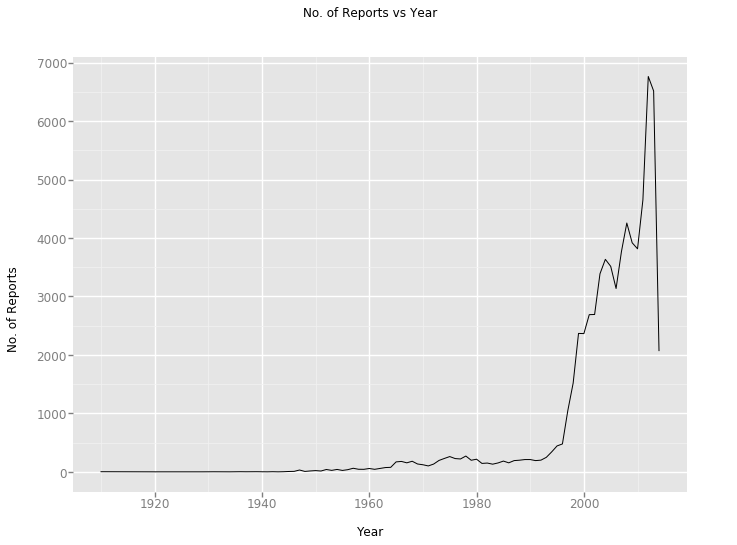

<ggplot: (-9223371929132445019)>

In [6]:
# making a line plot
ggplot(ufo_grouped, aes(x = 'Year', y = 'No. of Reports')) + \
    geom_line() + \
    labs(title="No. of Reports vs Year")

The number of reports of sightings seems to explode at the turn of the century (perhaps because of the X-Files). The drop at the end is because of the 2014 figure. We assume the data is not entirely complete for 2014.

Let's make a more interesting plot. Instead of year, let's plot the number of reports against month and see if there is a seasonality to UFO sightings.

In [7]:
# grouping by month, and dropping all columns but one
ufo_grouped = ufo_df.groupby(ufo_df['datetime'].dt.month, \
                             as_index=True, group_keys=True).size().reset_index(name='No. of Reports')
# changing labels
ufo_grouped = ufo_grouped.rename(columns={'datetime' : 'Month'})
ufo_grouped.head()

Month  No. of Reports
0      1            4866
1      2            3979
2      3            4674
3      4            4730
4      5            4552

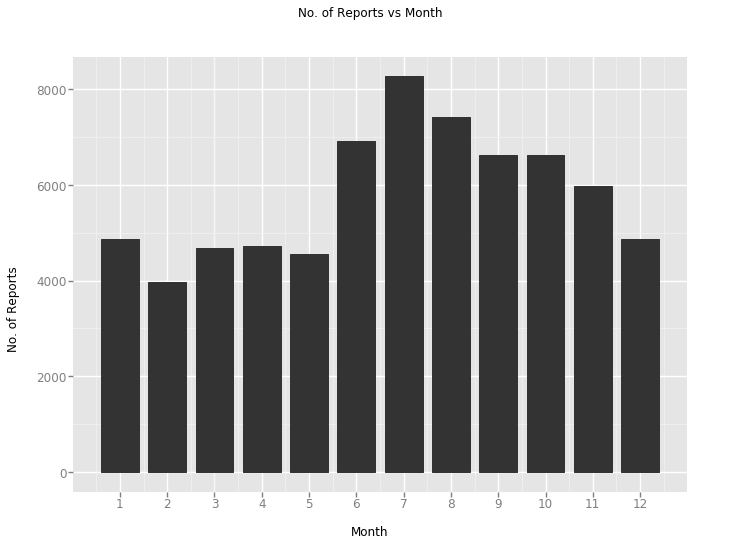

<ggplot: (-9223371929135325012)>

In [8]:
# making a bar chart
ggplot(aes(x = 'Month', weight = 'No. of Reports'), data=ufo_grouped) + \
    geom_bar(stat='identity') + \
    labs(title="No. of Reports vs Month", y = "No. of Reports")

It looks like most sightings occur in the summer and autumn - perhaps because of clearer skies and better weather. It seems July is the most common month when UFO sightings are reported. We have a hunch that this is related to July 4 fireworks. Let's get the average number of sightings for each month and plot that against month.

In [9]:
# putting year in a seperate column
ufo_df['Year'] = ufo_df['datetime'].dt.year
# grouping by month of each year
ufo_groupedym = ufo_df.groupby([ufo_df['datetime'].dt.month, ufo_df['Year']], \
                             as_index=True, group_keys=True).size().reset_index(name='No. of Reports')
# changing labels
ufo_groupedym = ufo_groupedym.rename(columns={'datetime' : 'Month'})

ufo_avg = ufo_groupedym.groupby(ufo_groupedym['Month'], as_index=True).mean().reset_index()
ufo_avg[['Month', 'No. of Reports']]

Month  No. of Reports
0       1       73.727273
1       2       64.177419
2       3       82.000000
3       4       76.290323
4       5       68.969697
5       6       89.935065
6       7      113.260274
7       8      107.652174
8       9      105.269841
9      10       98.880597
10     11       99.733333
11     12       78.467742

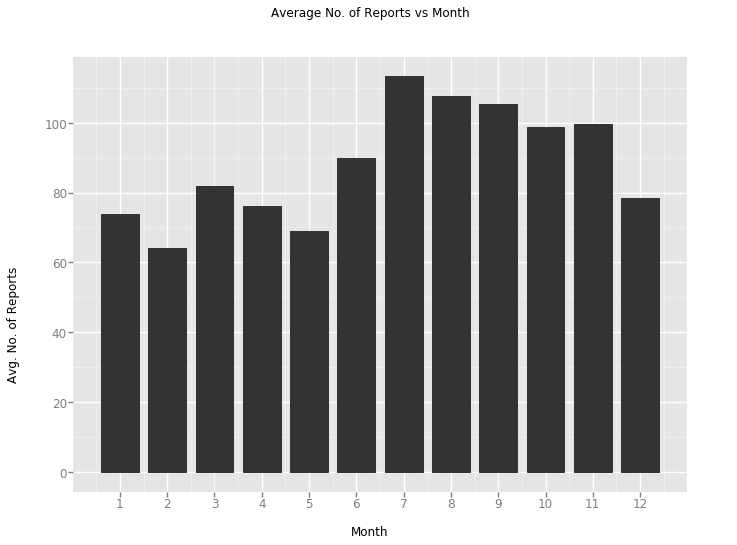

<ggplot: (-9223371929135257014)>

In [10]:
# making a bar chart
ggplot(aes(x = 'Month', weight = 'No. of Reports'), data=ufo_avg) + \
    geom_bar(stat='identity') + \
    labs(title="Average No. of Reports vs Month", y = "Avg. No. of Reports")

Look familiar? We get a graph similar to the "raw number of reports versus month" graph. However, an average is a more useful measurement. We can also plot the standard deviation for each month.

In [11]:
# calculating the standard deviation for each month
ufo_sd = ufo_groupedym.groupby(ufo_groupedym['Month'], as_index=True).std().reset_index()
ufo_sd[['Month', 'No. of Reports']]

Month  No. of Reports
0       1      133.892557
1       2      107.027884
2       3      123.810483
3       4      124.508791
4       5      110.497472
5       6      129.257631
6       7      197.114957
7       8      181.704821
8       9      172.496957
9      10      165.132685
10     11      166.970703
11     12      141.768539

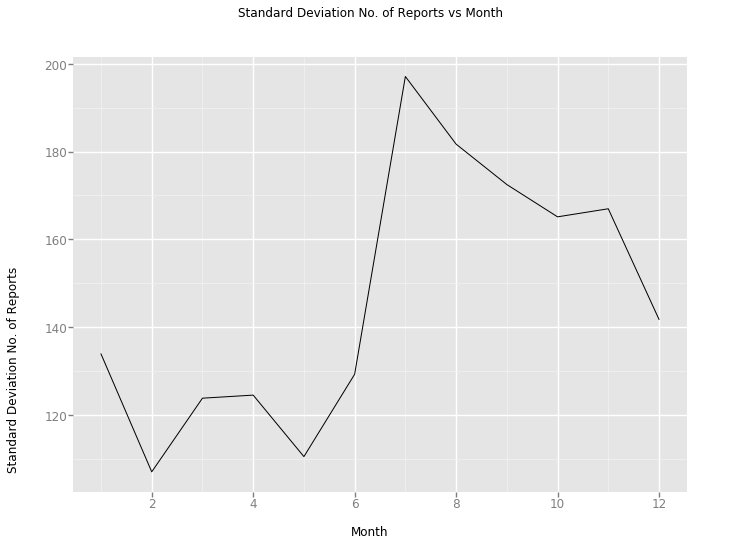

<ggplot: (107719518875)>

In [12]:
# making a line plot
ggplot(aes(x = 'Month', y = 'No. of Reports'), data=ufo_sd) + \
    geom_line(stat='identity') + \
    labs(title="Standard Deviation No. of Reports vs Month", y = "Standard Deviation No. of Reports")

Peak variance seems to be in July. That is also, coincidentally, the month with the peak number of sightings. Perhaps only a few years make up most of July's sightings. Let's make a violin plot to get an idea of the distribution for each month. We'll use the DataFrame grouped by each month of each year.

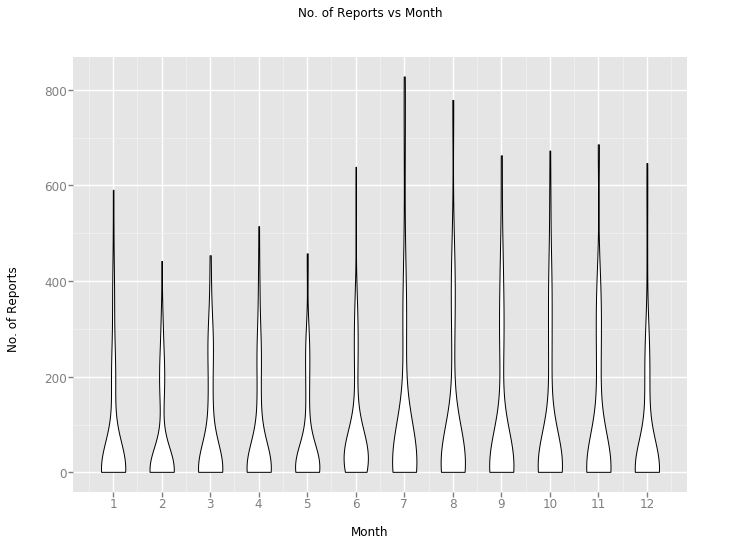

<ggplot: (-9223371929131827035)>

In [13]:
# making a violin plot
ggplot(aes(x = 'Month', y = 'No. of Reports'), data=ufo_groupedym) + \
    geom_violin(stat='identity') + \
    labs(title="No. of Reports vs Month", y = "No. of Reports")

As we suspected, July has outliers stretching its distribution higher than the other months.

Let's go further than months and plot number of reports against time of day. This may tell us the most likely time of day when one would encounter a UFO.

In [14]:
# grouping by hour
ufo_grouped = ufo_df.groupby(ufo_df['datetime'].dt.hour, \
                             as_index=True, group_keys=True).size().reset_index(name='No. of Reports')
# changing labels
ufo_grouped = ufo_grouped.rename(columns={'datetime' : 'Hour'})
ufo_grouped.head()

Hour  No. of Reports
0     0            4009
1     1            2755
2     2            1969
3     3            1693
4     4            1290

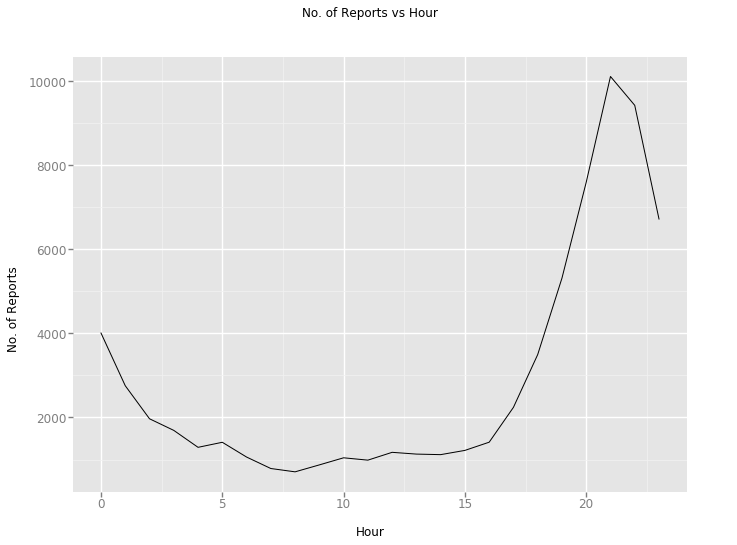

<ggplot: (-9223371929132288603)>

In [15]:
# making a line plot of number of reports vs hour
ggplot(aes(x = 'Hour', y = 'No. of Reports'), data=ufo_grouped) + \
    geom_line(stat='identity') + \
    labs(title="No. of Reports vs Hour", y = "No. of Reports")

As you might have guessed, most of the reports say the sightings occurred at night. It would be too convenient if UFOs appear during the day, after all.

Let's plot encounter duration for each year against year, and look for patterns. This time we'll make a scatter plot.

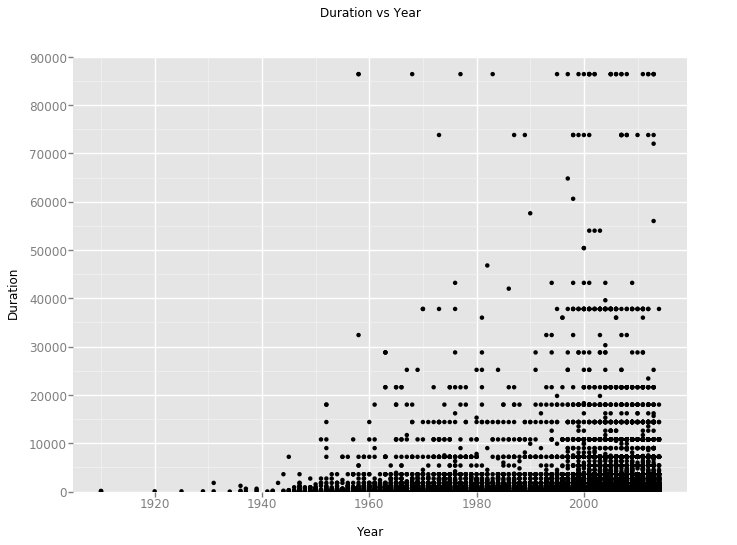

<ggplot: (107722790127)>

In [16]:
# scatter plot of duration over time
ggplot(ufo_df, aes('Year', 'duration (seconds)')) + \
    geom_point() + ylim(0,90000) +\
    labs(title="Duration vs Year", y = "Duration")

We're limiting the y-axis to 90,000 seconds because there are too many outliers, causing the scale to be too large. It seems like the majority of sightings have a duration of less than 10,000 seconds, but it may be increasing over time. Although it does not look linear, let's add a regression line and see what happens. We can do this easily with ggplot.

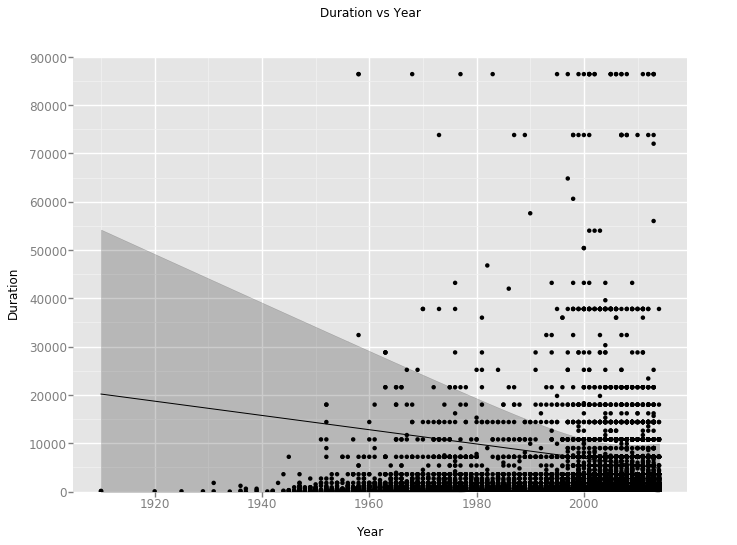

<ggplot: (107723153444)>

In [17]:
ggplot(ufo_df, aes('Year', 'duration (seconds)')) + \
    geom_point() + ylim(0,90000) +\
    stat_smooth(method='lm',formula = 'duration (seconds)~Year') +\
    labs(title="Duration vs Year", y = "Duration")

As you can see by the shaded region, a linear model is not a good fit for this data. We would have to try different models to find the best fit. However, we probably won't be able to find a good fit for this data since there does not appear to be any real relationship between duration and year. We likely won't learn anything meaningful from this, so let's see what other visualizations we can do.

### 2.2 Other Visualizations
Let's make a bar chart to see the most common UFO shapes reported. This time we'll use matplotlib. First we need to use the groupby function again to count the sightings with the same shapes.

In [18]:
# grouping by shape, and dropping all columns but one
ufo_grouped = ufo_df.groupby(ufo_df['shape'], \
                             as_index=True, group_keys=True).size().reset_index(name='No. of Reports')

# caluclating percentages of each shape
sum = ufo_grouped['No. of Reports'].sum()
ufo_grouped['Percentage'] = ufo_grouped['No. of Reports'] / sum

# show part of the dataframe
ufo_grouped.head()

shape  No. of Reports  Percentage
0   changed               1    0.000014
1  changing            1739    0.025012
2   chevron             870    0.012513
3     cigar            1784    0.025659
4    circle            6716    0.096594

Now we make a bar chart.

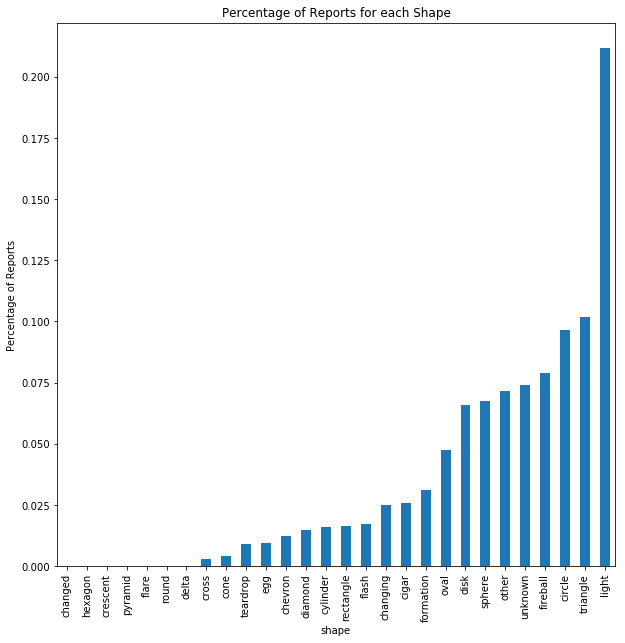

In [19]:
# sorting
ufo_grouped = ufo_grouped.sort_values(by='Percentage')

# make a bar chart
ax = ufo_grouped.plot.bar(x = 'shape', y = 'Percentage', \
                          figsize=(10,10), title = 'Percentage of Reports for each Shape', legend=False)
ax.set_ylabel('Percentage of Reports')
plt.show()

Over 20% of the reports describe the UFO, while around 11% describe the UFO as a triangle and 10% as a circle. The rest of the shapes were reported in smaller percentages than 10.

Now let's use those coordinates in our DataFrame and make a map of the sightings. [Folium](https://folium.readthedocs.io/en/latest/) will come in handy here. You can make several kinds of maps with folium, but we'll just make a heat map. This way we'll be able to see where most sightings occur. To keep things simple, we'll only look at sightings in the US.

In [20]:
# creating the map
themap = folium.Map(location=[37.0902, -95.7129], zoom_start = 4) 

# ensure the coordinates are treated as floats
ufo_df['Latitude'] = ufo_df['latitude'].astype(float)
ufo_df['Longitude'] = ufo_df['longitude'].astype(float)

# filter the DataFrame for rows, then columns
heat_df = ufo_df[ufo_df['country'] == 'us'].sample(55000)
heat_df = heat_df[['Latitude', 'Longitude']]

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius = 7, blur=15, min_opacity = 3, max_zoom = 4).add_to(themap)

# Display the map
themap

Looks like sightings occur mostly in more urban areas of the country. There are pockets of emptiness in the northern, slightly western, part of the country (i.e. the Dakotas, Montana, Wyoming). If you zoom in, you can see that the sightings are concentrated around major cities. Coincidentally, majors cities are typically near airports. Let's add markers for airports using the coordinates in our airports DataFrame.

In [21]:
# Ensure the coordinates are treated as floats
air_df['Latitude'] = air_df['latitude'].astype(float)
air_df['Longitude'] = air_df['longitude'].astype(float)

# adding markers for airports
for i,row in air_df.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], radius=1, color='black', fill_color='black').add_to(themap)

# Display the map
themap

Eyeballing the map, it seems like UFO sightings tend to cluster around airports. It's even more evident when zooming in, as many airports are directly on top of areas marked by the heat map. The more airports in an area, the more sightings. On the other hand, an area with several airports is typically an area with a high population density. Planes or aliens? You can never be too sure, some would say.

We should investigate this relationship between airports and sightings by finding the distance between a given sighting and the nearest airport. We can do this using the [vincenty](https://geopy.readthedocs.io/en/1.10.0/#module-geopy.distance) method in geopy. The method calculates the distance between two geographic positions. Here is where our airports DataFrame will come in handy. First, we'll write a method that returns the distance between a sighting and the nearest airport in miles. This will lead us to our next section, hypothesis testing.

In [22]:
def dist(lat,long):
    shortest_distance = None

    # go through each airport in the DataFrame to find the nearest one
    for i,row in air_df.iterrows():
        distance = vincenty((lat,long), (row['latitude'],row['longitude'])).miles
        if shortest_distance is None or distance < shortest_distance:
            # replace current shortest distance with new shortest distance
            shortest_distance = distance
    return shortest_distance

## 3. Hypothesis Testing
As a data scientist, you'll often find yourself wanting to test a hypothesis. Luckily, hypothesis testing is a an important part of data science and statistics. We'll be doing the P-value approach. The idea is that you make an assumption (a null hypothesis), then you collect sample data and calculate the test statistic and p-value, and then based on these values, and your significance level (usually 0.05) you either reject the null hypothesis or you fail to reject it. Note that we are **not** proving the hypothesis. We are finding the probability that we get values at least as extreme as the ones we get from sample data, given that the null hypothesis is true.

Let's do some hypothesis testing of our own. We'll be performing a [one sample t-test](http://www.statisticssolutions.com/manova-analysis-one-sample-t-test/) using [scipy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_1samp.html). Our null hypothesis will be that the average UFO sighting in the U.S. is greater than 10 miles away from an airport. In other words, we think the mean distance between UFO sightings in the U.S. and an airport is less than or equal to 10 miles. Our significance level will be 0.05. As much as we would love to get the mean of the entire dataset, our method of finding the distance to the nearest airport for each sighting is extremely slow (it has a quadratic time complexity); especially since we have over 80,000 sightings in our data set and there are about 1,500 airports in the U.S (the airports dataset doesn't include state). A hypothesis test will save us from the torture of slow computing. With a confidence level of 95% and a margin of error of around 3%, we'll take a random sample of 1000 sightings.

In [23]:
# creating column to hold distance to closest airport
ufo_df['closest airport'] = 0.0
sample_df = ufo_df[ufo_df['country'] == 'us'].sample(1000)

# calculating distance for each sighting
for i,row in sample_df.iterrows():
    sample_df.loc[i,'closest airport'] = dist(row['latitude'],row['longitude'])
    
sample_df[['datetime','latitude','longitude','closest airport']].head()

datetime    latitude   longitude  closest airport
80830 2007-09-11 09:00:00     32.2217 -110.925833         4.554838
25901 2013-01-27 22:57:00  40.4147222  -74.365833        15.373128
25601 1998-01-27 20:20:00  47.7544444 -122.162222        11.879363
10160 2008-11-14 21:00:00  48.7600000  -98.367778        51.086476
7605  2004-10-07 18:45:00  44.9180556  -73.124722        25.008916

Now we perform the t-test. Note that the scipy t-test is two-tailed, but since we our null hypothesis is for "less than 30" we need to divide the p-value by 2.

In [24]:
# performing t-test
(t,p) = scipy.stats.ttest_1samp(sample_df['closest airport'],10)
print(t) # printing test statistic
print(p/2) # printing p-value

3.08851086421
0.00103359376056


According to [this](https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy) stackoverflow post asking about this scipy function, when the p-value/2 is less than our significance level and the test statistic 't' is greater than zero, we can reject our null hypothesis. Since our significance level is 0.05, we can indeed reject the null hypothesis of the average UFO sighting occurring greater than 10 miles away from an airport. Thus, by default, we accept our alternative hypothesis that the average sighting is within 10 miles of an airport.

## 4. Machine Learning

A big part of data science is machine learning. The basic premise behind machine learning is this: you feed the machine a large amount of data, the machine trains on this data, and then it makes decisions/predictions without the programmer's input. This is all done with the power of algorithms. There are 3 main types of machine learning algorithms, supervised (where we know the correct outcome and are testing the accuracy of the machine), unsupervised (where there is no target outcome and the machine tries to find the structure of a dataset), and reinforcement (where the machine trains itself through trial and error).

Since we have some nice geospatial data, we'll be doing some unsupervised learning in the form of clustering. Clustering is about grouping data in such a way that the data points within a group are more similar to each other than data points in other groups. In the context of our tutorial: since many sightings occur near each other we can use clustering to reduce the number of points in our dataset and save on computing power. We'll be using [scikit-learn](http://scikit-learn.org/stable/index.html), a useful package of machine learning algoritihms. Specifically we'll use [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), an award winning clustering algorithm good for spatial data. We need to save the coordinates as a matrix, then run the algorithm using the matrix as input. We consider points within 10 miles to be of the same cluster, but we need to convert this to radians by dividing 10 by the Earth's radius (3958.7613 miles) to use the haversine metric. We use the ball tree algorithm and haversine metric to calculate distances between points. 

In [25]:
# getting US sightings coordinates
ufo_df = ufo_df[ufo_df['country']=='us']
coords = ufo_df.as_matrix(columns=['Latitude','Longitude'])

# running the algorithm
db = DBSCAN(eps=(10/3958.7613), min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) # getting number of clusters

print("Reduced %d points to %d points" %(len(ufo_df),num_clusters))

Reduced 66411 points to 3702 points


We've significantly reduced the number of data points. To get the coordinates for each cluster, we need to find its center. We use MultiPoint from the [Shapely](https://toblerity.org/shapely/modules.html) package to calculate the centroid of the cluster. Then we find the data point in the cluster closest to the centroid, and use that as the center point. We write this as a function that we'll apply to each cluster.

In [26]:
def get_center_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    center_point = min(cluster, key=lambda point: vincenty(point, centroid).miles)
    return tuple(center_point)

We apply the function to each cluster, and store the center points in a dataframe.

In [27]:
# get the clusters
clusters = pd.Series([coords[cluster_labels==x] for x in range(num_clusters)])
# apply function to each cluster to get center point tuples
center_points = clusters.map(get_center_point)

# unzip the tuples
lats, lons = zip(*center_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.head()

Latitude   Longitude
0  29.883056  -97.941111
1  28.978333  -96.645833
2  21.382222 -157.933611
3  36.348611  -82.210833
4  41.162778  -73.861944

Finally, we plot our original data points and the clusters to compare the two.

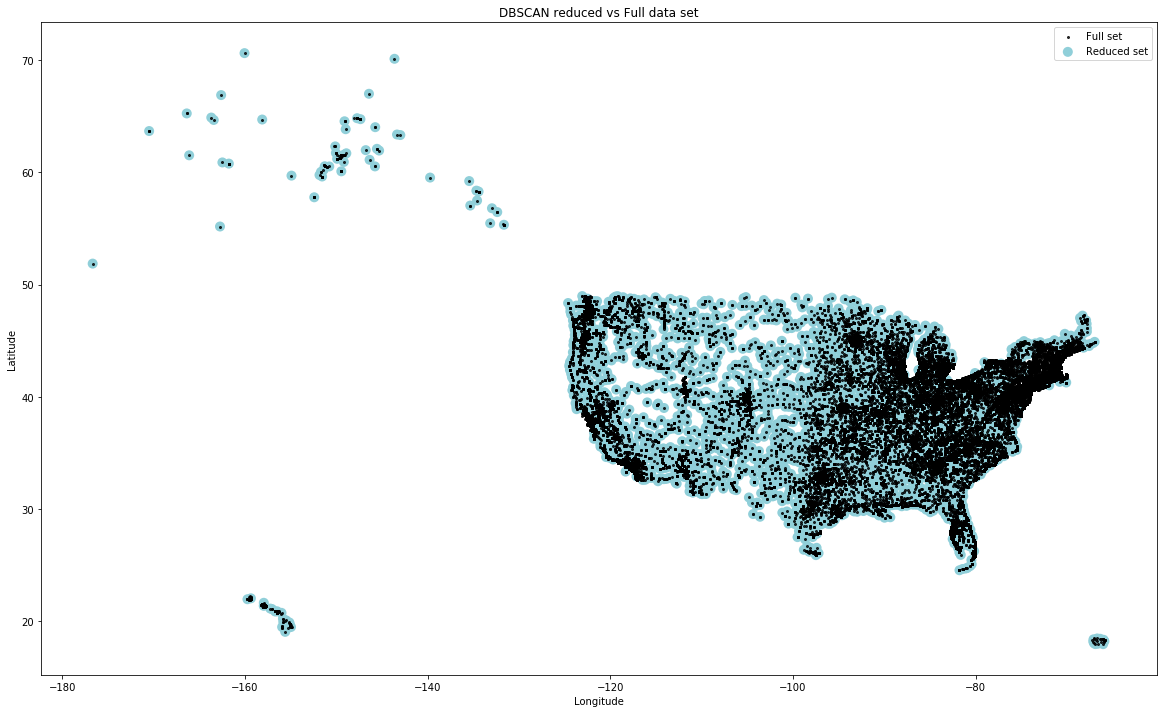

In [28]:
fig, ax = plt.subplots(figsize=[20, 12])
rep_points_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='#90cfd9', edgecolor='None',s=100)
ufo_df_scatter = ax.scatter(ufo_df['Longitude'], ufo_df['Latitude'], c='k', alpha=.8, s=4)
ax.set_title('DBSCAN reduced vs Full data set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([ufo_df_scatter, rep_points_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

The clusters appear to fit the data very well. Hopefully this makes the benefits of clustering clear by now. Plotting 66,000 points is unnecessary on such a large scale, particularly when many of the points are practically right on top of each other.

## 5. Insights

Real or hoax? Are the governments of the world conspiring to hide the truth about visitors from outer space? Taking off our tin foil hats, everything we've done in this tutorial (along with a healthy dose of skepticism) leads us to believe that UFO sightings are simply conclusions drawn from incomplete information. From fireworks to aircraft and drones, lots of things are flying in the sky of our bustling, modern world. We believe that one of the greatest dangers of our world today is misinformation. One way to protect yourself from this is by diving into the data, analyzing it, and drawing your own conclusions.

We hope that our tutorial has taught you something useful you can use in your life and/or career. Feel free to perform some data science of your own with the dataset we've used. And remember, have fun with it!